In [15]:
import os
import pandas as pd
import random
import logging
from ecg_utils import get_hea_file_paths, load_ecg, preprocess_data, compute_snr

# --------------------------------------------------
# Config
# --------------------------------------------------
computer = 1

# Define paths based on environment
if computer:
    data_directory_path = "/Users/sinahassannia/Desktop/ptbxl_dataset/records500"
    core_path_results = "/Users/sinahassannia/Documents/emory/research/ecg_recons/results"
    metadata_csv_path = "/Users/sinahassannia/Desktop/ptbxl_dataset/ptbxl_database.csv"
else:
    data_directory_path = "/labs/samenilab/team/sina_hassannia/data/ptbxl/physionet.org/files/ptb-xl/1.0.3/records500/"
    core_path_results = "/labs/samenilab/team/sina_hassannia/codes/ecg_sep/ecg_sepration/results/"
    metadata_csv_path = "/labs/samenilab/team/sina_hassannia/data/ptbxl/physionet.org/files/ptb-xl/1.0.3/ptbxl_database.csv"
    fiducial_path = "/labs/samenilab/team/sina_hassannia/active_projects/ecg_sepration/results/fiducial_results/ecg_fiducials_ptbxl_lead II.csv"


# --------------------------------------------------
# Load metadata
# --------------------------------------------------
metadata_df = pd.read_csv(metadata_csv_path)

# --------------------------------------------------
# Get and split data
# --------------------------------------------------
hea_files = get_hea_file_paths(data_directory_path)
random.seed(42)
random.shuffle(hea_files)

split_idx = int(0.8 * len(hea_files))
record_paths_train = hea_files[:split_idx]
record_paths_val = hea_files[split_idx:]

# Limit dataset size for local run
if computer:
    record_paths_train = record_paths_train[:15000]
    record_paths_val = record_paths_val[:1000]

print(f"Total records: {len(hea_files)}")
print(f"Training records: {len(record_paths_train)}")
print(f"Validation records: {len(record_paths_val)}")


Total records: 21837
Training records: 15000
Validation records: 1000


In [16]:
# kalman_fir_multi.py

import numpy as np

import numpy as np

def build_regressors_multi(x, order):
    """
    Zero-padded multichannel FIR regressor.

    Parameters
    ----------
    x : array_like, shape (N, L_in)
        Input signals (all source leads).

    order : int
        FIR order (q).

    Returns
    -------
    Phi : np.ndarray, shape (N, (order + 1) * L_in)
        Each row t contains:
          [ x_t(:), x_{t-1}(:), ..., x_{t-order}(:) ]
        with zero-padding applied for t < order.

    y_idx_start : int
        Always 0 (no truncation).
    """
    x = np.asarray(x)
    if x.ndim != 2:
        raise ValueError("x must be 2D with shape (N, L_in)")

    N, L_in = x.shape
    M = (order + 1) * L_in

    # Explicit zero-padding in time
    x_pad = np.zeros((N + order, L_in), dtype=float)
    x_pad[order:, :] = x

    Phi = np.zeros((N, M), dtype=float)

    for t in range(N):
        idx = t + order
        for lag in range(order + 1):
            start = lag * L_in
            end = (lag + 1) * L_in
            Phi[t, start:end] = x_pad[idx - lag, :]

    return Phi, 0




import numpy as np

def kalman_adaptive_fir_multi(x, y, order=4, q_var=1e-6, r_var=1e-3, h0=None, P0=None):
    x = np.asarray(x)
    y = np.asarray(y).reshape(-1)

    if x.ndim != 2:
        raise ValueError("x must be 2D: shape (N, L_in)")
    N, L_in = x.shape
    if y.shape[0] != N:
        raise ValueError("x and y must have the same number of samples")

    Phi, offset = build_regressors_multi(x, order)
    T, M = Phi.shape
    if T != N or offset != 0:
        raise ValueError("Expected zero-padded regressors: Phi.shape[0]==N and offset==0")

    h = np.zeros(M) if h0 is None else np.asarray(h0, float).copy()
    P = np.eye(M) if P0 is None else np.asarray(P0, float).copy()

    Q = np.eye(M) * float(q_var)
    R = float(r_var)
    if R <= 0:
        raise ValueError("r_var (R) must be > 0")

    I_M = np.eye(M)

    y_hat = np.zeros(N, float)
    h_hist = np.zeros((N, M), float)
    innovations = np.zeros(N, float)
    K_hist = np.zeros((N, M), float)

    S_hist = np.zeros(N, float)
    P_diag_hist = np.zeros((N, M), float)

    # NEW: store model-only term m_t = phi P_pred phi^T
    model_term_hist = np.zeros(N, float)

    for t in range(N):
        phi_t = Phi[t, :]
        y_t = y[t]

        # predict
        h_pred = h.copy()
        P_pred = P + Q

        # innovation
        y_pred = phi_t @ h_pred
        innov = y_t - y_pred

        # NEW: model term and S
        model_term = float(phi_t @ P_pred @ phi_t)
        model_term_hist[t] = model_term

        S = model_term + R
        S = max(S, 1e-12)

        K = (P_pred @ phi_t) / S

        # update
        h = h_pred + K * innov
        A = I_M - np.outer(K, phi_t)
        P = A @ P_pred @ A.T + R * np.outer(K, K)
        P = 0.5 * (P + P.T)

        # save
        y_hat[t] = phi_t @ h
        h_hist[t, :] = h
        innovations[t] = innov
        K_hist[t, :] = K

        S_hist[t] = S
        P_diag_hist[t, :] = np.diag(P)

    # NEW: return model_term_hist as 7th output
    return y_hat, h_hist, innovations, K_hist, S_hist, P_diag_hist, model_term_hist


In [17]:
import numpy as np

def estimate_Q_R_on_dataset(
    record_paths,
    order,
    q_var_init=1e-6,
    r_var_init=1e-3,
    leads=None,
    max_records=500,
    n_iters=2,
    burn_in=500,          # <-- IMPORTANT: use a burn-in (e.g., 500-1000 samples)
    eps=1e-12,
    verbose=True,
    r_floor_frac=1e-4,    # <-- NEW: scale-aware minimum R = r_floor_frac * var(y)
):
    """
    Estimate scalar q_var and r_var for the multi-lead Kalman adaptive FIR model.

    OPTION B (principled R):
      R ≈ E[ nu_t^2 - phi_t P_{t|t-1} phi_t^T ]
    This requires kalman_adaptive_fir_multi to return model_term_hist.

    Robustified to avoid R collapsing to ~0:
      - only use positive (nu^2 - model_term) samples
      - enforce a scale-aware lower bound R_min = r_floor_frac * var(y)
      - use burn_in to skip early transient where P can be large

    Returns
    -------
    q_est : float
    r_est : float
    """
    if leads is None or len(leads) != 2:
        raise ValueError("leads must be a tuple: (target_lead, input_leads)")

    target_lead, input_leads = leads
    if isinstance(input_leads, tuple):
        input_leads = list(input_leads)
    if not isinstance(input_leads, list) or len(input_leads) == 0:
        raise ValueError("input_leads must be a non-empty list of lead names")

    paths = list(record_paths)
    if max_records is not None:
        paths = paths[:max_records]

    q_var = float(q_var_init)
    r_var = float(r_var_init)

    for it in range(n_iters):
        r_acc = []
        q_acc = []
        n_used = 0

        for path in paths:
            selected = input_leads + [target_lead]
            signal, record = load_ecg(path, selected_leads=selected)

            fs = record.fs
            signal = preprocess_data(signal, fs)

            x = signal[:, :len(input_leads)]
            y = signal[:, len(input_leads)]

            # Run filter (UPDATED: returns model_term_hist)
            (
                y_hat,
                h_hist,
                innovations,
                K_hist,
                S_hist,
                P_diag_hist,
                model_term_hist,
            ) = kalman_adaptive_fir_multi(
                x=x, y=y, order=order, q_var=q_var, r_var=r_var
            )

            start = int(max(0, burn_in))
            if start >= innovations.shape[0]:
                continue

            nu = innovations[start:]      # innovation: y - y_pred
            m  = model_term_hist[start:]  # model term: phi P_pred phi^T
            if nu.size == 0:
                continue

            # Scale-aware lower bound for R (prevents collapse)
            R_min = float(r_floor_frac) * float(np.var(y))
            R_min = max(R_min, eps)

            # --- Robust R estimate: E[nu^2 - m]
            r_samples = nu**2 - m
            r_samples = r_samples[np.isfinite(r_samples)]
            r_samples = r_samples[r_samples > 0.0]

            if r_samples.size > 0:
                r_hat = float(np.median(r_samples))  # robust to outliers (QRS)
                r_acc.append(max(r_hat, R_min))
            else:
                # Fallback if everything is negative: keep at least R_min
                r_acc.append(R_min)

            # --- Q estimate (same as you had) ---
            if h_hist.shape[0] > start + 1:
                dh = np.diff(h_hist[start:, :], axis=0)
                q_acc.append(float(np.mean(dh**2)))

            n_used += 1

        if n_used == 0:
            raise RuntimeError("No usable records for Q/R estimation (check loading/preprocess).")

        r_new = float(np.median(r_acc)) if len(r_acc) else r_var
        q_new = float(np.median(q_acc)) if len(q_acc) else q_var

        # Final safety floors
        r_var = max(r_new, eps)
        q_var = max(q_new, eps)

        if verbose:
            print(f"[iter {it+1}/{n_iters}] q_var={q_var:.6e}, r_var={r_var:.6e}")

    return q_var, r_var


In [18]:
from ecg_utils import load_ecg, preprocess_data, compute_snr
import numpy as np
import matplotlib.pyplot as plt

# ----------------------------
# Config
# ----------------------------
leads = ["I", "II", "V1", "V2", "V3", "V4", "V5", "V6"]
order = 4

q_var_init = 1e-3
r_var_init = 1e-3
max_records = 400 #len(record_paths_train)
n_iters = 4

# record_paths_train = [...]
# record_paths_val   = [...]


# ----------------------------
# Core runner for one target lead
# ----------------------------
def run_one_target_lead(
    target_lead,
    record_paths_train,
    record_paths_val,
    order=4,
    q_var_init=1e-3,
    r_var_init=1e-3,
    max_records=2000,
    n_iters=4,
):
    """
    Train (estimate Q/R) using record_paths_train, then evaluate on record_paths_val
    for a single target lead reconstructed from the remaining leads.

    Returns a dict including:
      - per-record validation SNRs
      - avg validation SNR
      - per-record Kalman outputs:
          y_hat, h_hist, innovations, K_hist, S_hist, P_diag
    """
    input_leads = [ld for ld in leads if ld != target_lead]
    leads_tuple = (target_lead, input_leads)

    # ----------------------------
    # 1) Estimate Q/R on train
    # ----------------------------
    q_est, r_est = estimate_Q_R_on_dataset(
        record_paths=record_paths_train,
        order=order,
        q_var_init=q_var_init,
        r_var_init=r_var_init,
        leads=leads_tuple,
        max_records=max_records,
        n_iters=n_iters,
    )
    q_var, r_var = q_est, r_est
    r_var =  r_var

    # ----------------------------
    # 2) Evaluate on validation
    # ----------------------------
    snrs_val = []

    # Store per-record outputs
    y_hat_list = []
    h_hist_list = []
    innovations_list = []
    K_hist_list = []
    S_hist_list = []
    P_diag_list = []

    selected_leads = [target_lead] + input_leads  # y is column 0

    for path in record_paths_val:
        try:
            signal, record = load_ecg(path, selected_leads=selected_leads)
            signal = preprocess_data(signal, record.fs)

            y = signal[:, 0]
            x = signal[:, 1:]

            # Kalman FIR (UPDATED: kalman_adaptive_fir_multi returns 7 outputs now)
            y_hat, h_hist, innovations, K_hist, S_hist, P_diag_hist, _ = kalman_adaptive_fir_multi(
                x=x, y=y, order=order, q_var=q_var, r_var=r_var
            )

            # Robust validity mask
            valid = np.isfinite(y_hat) & np.isfinite(y)
            if np.any(valid):
                snrs_val.append(compute_snr(y[valid], y_hat[valid]))

            # Store full sequences (one entry per record)
            y_hat_list.append(y_hat)                # (T,)
            h_hist_list.append(h_hist)              # (T, M)
            innovations_list.append(innovations)    # (T,)
            K_hist_list.append(K_hist)              # (T, M)
            S_hist_list.append(S_hist)              # (T,)
            P_diag_list.append(P_diag_hist)         # (T, M)

        except Exception as e:
            print(f"[{target_lead}] Skipping {path}: {e}")

    avg_snr = np.nanmean(snrs_val) if snrs_val else np.nan

    return {
        "target_lead": target_lead,
        "input_leads": input_leads,
        "q_var": float(q_var),
        "r_var": float(r_var),

        # SNR stats
        "snrs_val": snrs_val,
        "avg_snr_val": avg_snr,
        "n_val_used": int(np.sum(np.isfinite(snrs_val))) if snrs_val else 0,

        # Kalman outputs (per validation record)
        "y_hat_list": y_hat_list,                  # list of (T,)
        "h_hist_list": h_hist_list,                # list of (T, M)
        "innovations_list": innovations_list,       # list of (T,)
        "K_hist_list": K_hist_list,                # list of (T, M)
        "S_hist_list": S_hist_list,                # list of (T,)
        "P_diag_list": P_diag_list,                # list of (T, M)
    }

# ----------------------------
# Run for all leads
# ----------------------------
results = {}

# ----------------------------
# Run for all leads
# ----------------------------
# for target_lead in leads:
#     results[target_lead] = run_one_target_lead(
#         target_lead=target_lead,
#         record_paths_train=record_paths_train,
#         record_paths_val=record_paths_val[0:200],
#         order=order,
#         q_var_init=q_var_init,
#         r_var_init=r_var_init,
#         max_records=max_records,
#         n_iters=n_iters,
#     )

from joblib import Parallel, delayed

def _worker(target_lead):
    return target_lead, run_one_target_lead(
        target_lead=target_lead,
        record_paths_train=record_paths_train,
        record_paths_val=record_paths_val[:1000],
        order=order,
        q_var_init=q_var_init,
        r_var_init=r_var_init,
        max_records=max_records,
        n_iters=n_iters,
    )

results = dict(
    Parallel(n_jobs=4, backend="loky")(
        delayed(_worker)(target_lead) for target_lead in leads
    )
)


# ----------------------------
# Prepare SNR arrays per lead (safe + finite only)
# ----------------------------
snr_per_lead = {ld: results.get(ld, {}).get("snrs_val", []) for ld in leads}

snr_arrays = []
for ld in leads:
    arr = np.asarray(snr_per_lead[ld], dtype=float)
    arr = arr[np.isfinite(arr)]
    snr_arrays.append(arr)

# ----------------------------
# Print summary
# ----------------------------
print("\nPer-target-lead validation SNR:")
for ld in leads:
    r = results[ld]
    avg = r.get("avg_snr_val", np.nan)
    qv = r.get("q_var", np.nan)
    rv = r.get("r_var", np.nan)
    n  = r.get("n_val_used", 0)

    avg_str = f"{avg:.3f}" if np.isfinite(avg) else "nan"
    q_str   = f"{qv:.3e}" if np.isfinite(qv) else "nan"
    r_str   = f"{rv:.3e}" if np.isfinite(rv) else "nan"

    print(f"{ld:>3} | avg SNR: {avg_str} | q: {q_str} | r: {r_str} | n: {n}")

valid_leads = [ld for ld in leads if np.isfinite(results[ld].get("avg_snr_val", np.nan))]
best = max(valid_leads, key=lambda ld: results[ld]["avg_snr_val"]) if valid_leads else None

if best is not None:
    print(f"\nBest target lead: {best} (avg SNR {results[best]['avg_snr_val']:.3f})")
else:
    print("\nNo valid SNRs for any target lead.")

# ----------------------------
# Box plot (skip empty arrays)
# ----------------------------
leads_for_plot = [ld for ld, arr in zip(leads, snr_arrays) if arr.size > 0]
arrays_for_plot = [arr for arr in snr_arrays if arr.size > 0]

# plt.figure(figsize=(10, 5))
# if arrays_for_plot:
#     plt.boxplot(arrays_for_plot, labels=leads_for_plot, showfliers=True)
#     plt.ylabel("SNR (dB)")
#     plt.xlabel("Target lead")
#     plt.title("Validation SNR per Target Lead")
#     plt.grid(True, axis="y")
#     plt.tight_layout()
#     plt.show()
# else:
#     print("\nNo finite SNR values available for boxplot; skipping plot.")

# ----------------------------
# Optional: long-form arrays (useful for pandas/seaborn)
# ----------------------------
snr_values = []
snr_labels = []

for ld in leads:
    for snr in results[ld].get("snrs_val", []):
        if np.isfinite(snr):
            snr_values.append(float(snr))
            snr_labels.append(ld)

snr_values = np.asarray(snr_values, dtype=float)
snr_labels = np.asarray(snr_labels, dtype=str)


[iter 1/4] q_var=4.717677e-05, r_var=1.644235e-04
[iter 1/4] q_var=4.774026e-05, r_var=1.626454e-04
[iter 1/4] q_var=2.935130e-05, r_var=1.272719e-04
[iter 1/4] q_var=3.126384e-05, r_var=1.019073e-04
[iter 2/4] q_var=4.223065e-05, r_var=7.848873e-05
[iter 2/4] q_var=3.904972e-05, r_var=8.258590e-05
[iter 2/4] q_var=2.651995e-05, r_var=5.434632e-05
[iter 2/4] q_var=3.085067e-05, r_var=5.002885e-05
[iter 3/4] q_var=4.855157e-05, r_var=6.495922e-05
[iter 3/4] q_var=5.078780e-05, r_var=6.007832e-05
[iter 3/4] q_var=3.217969e-05, r_var=3.898519e-05
[iter 3/4] q_var=3.700051e-05, r_var=3.779448e-05
[iter 4/4] q_var=5.489532e-05, r_var=5.898755e-05
[iter 4/4] q_var=5.606522e-05, r_var=5.413976e-05
[iter 4/4] q_var=3.578513e-05, r_var=3.435690e-05
[iter 4/4] q_var=4.051088e-05, r_var=3.348360e-05
[iter 1/4] q_var=1.913804e-05, r_var=5.695298e-05
[iter 1/4] q_var=1.639927e-05, r_var=5.883121e-05
[iter 2/4] q_var=1.931996e-05, r_var=2.955967e-05
[iter 1/4] q_var=1.345210e-05, r_var=4.273200e-05


/var/folders/vc/8z0y3p692pjcv1x3wndz_g2w0000gn/T/ipykernel_913/1300158118.py:15: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(snr_arrays,


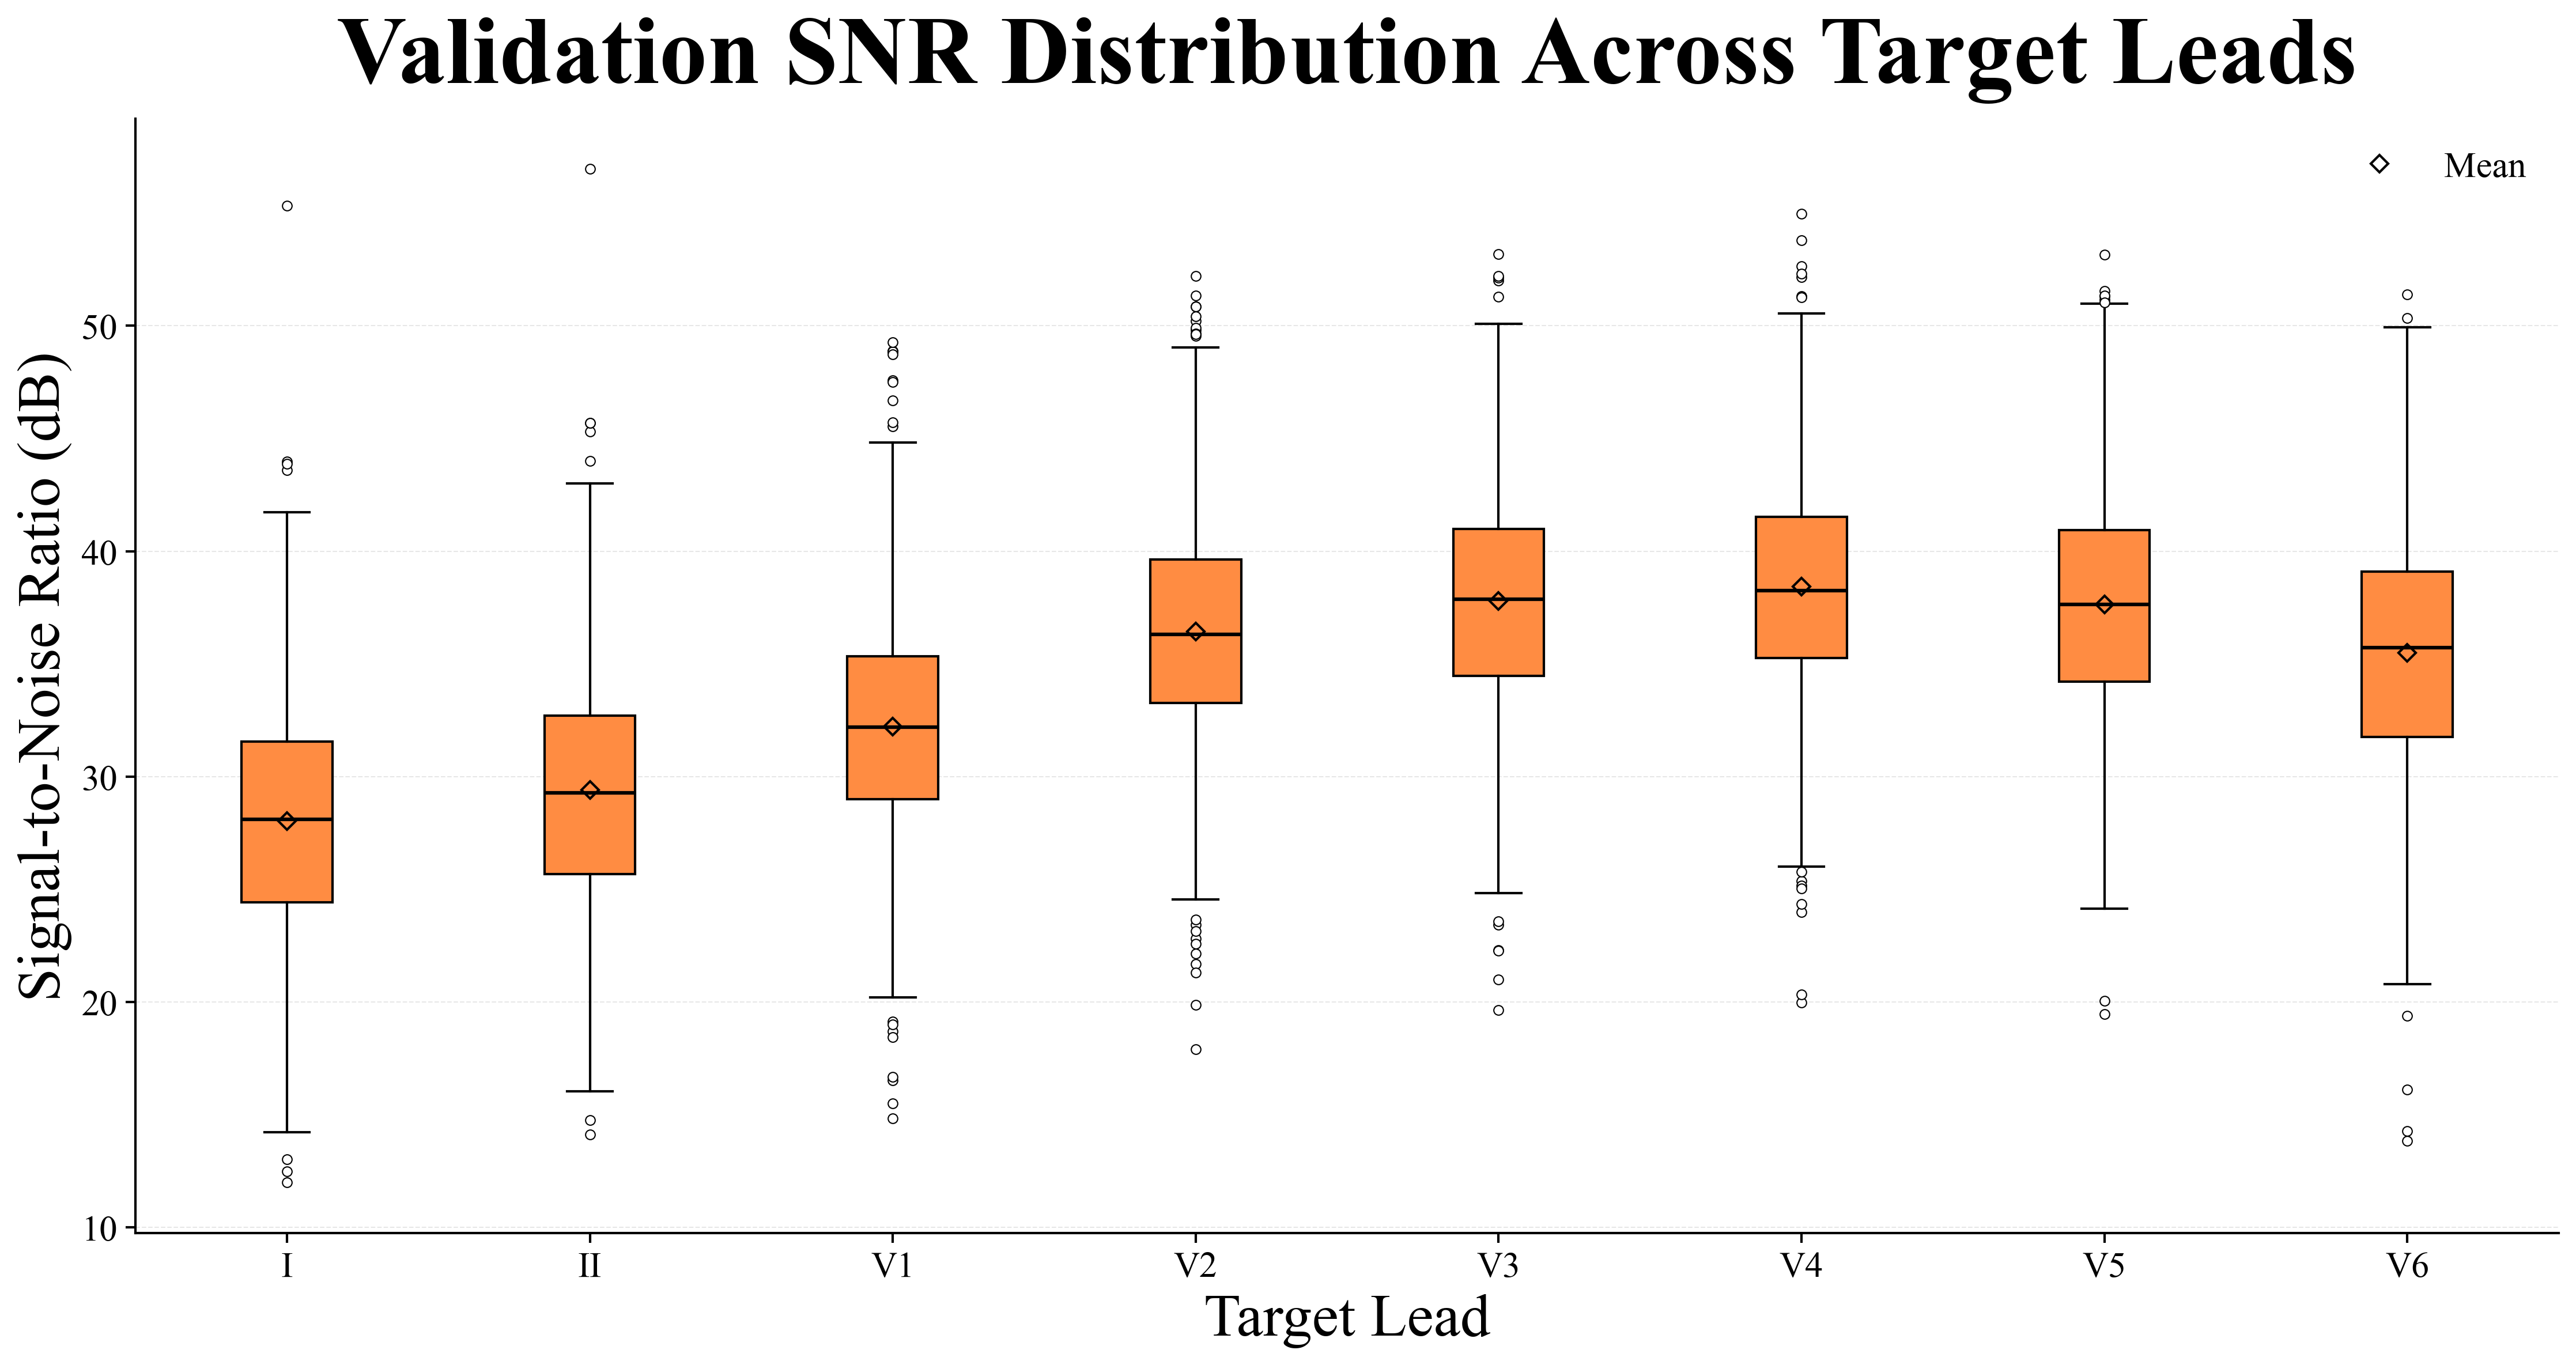

In [86]:
# ----------------------------
# Visualization of Box plots 

# Set publication-quality parameters
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman', 'DejaVu Serif']
plt.rcParams['font.size'] = 10
plt.rcParams['axes.linewidth'] = 1.0
plt.rcParams['grid.linewidth'] = 0.5
plt.rcParams['lines.linewidth'] = 1.0

fig, ax = plt.subplots(figsize=(15, 8), dpi=300)

# Create box plot with custom styling
bp = ax.boxplot(snr_arrays, 
                labels=leads,
                patch_artist=True,
                showfliers=True,
                widths=0.3,
                medianprops=dict(color='black', linewidth=1.5),
                boxprops=dict(facecolor="#FF8C42", edgecolor='black', linewidth=1.0),
                whiskerprops=dict(color='black', linewidth=1.0),
                capprops=dict(color='black', linewidth=1.0),
                flierprops=dict(marker='o', markerfacecolor='white', 
                               markeredgecolor='black', markersize=4, 
                               linestyle='none', markeredgewidth=0.5))

# Axis labels with proper formatting
ax.set_ylabel('Signal-to-Noise Ratio (dB)', fontsize=25, fontweight='normal')
ax.set_xlabel('Target Lead', fontsize=25, fontweight='normal')
ax.set_title('Validation SNR Distribution Across Target Leads', 
             fontsize=40, fontweight='bold', pad=15)

# Grid styling
ax.grid(True, axis='y', linestyle='--', alpha=0.3, linewidth=0.5)
ax.set_axisbelow(True)

# Spine styling
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_linewidth(1.0)
ax.spines['bottom'].set_linewidth(1.0)

# Tick parameters
ax.tick_params(axis='both', which='major', labelsize=15, 
               length=4, width=1.0, direction='out')

# Optional: Add statistical annotations (mean as a point)
means = [np.mean(arr) for arr in snr_arrays]
ax.plot(range(1, len(means) + 1), means, 'D', 
        color='black', markersize=5, label='Mean', 
        markerfacecolor='none', markeredgewidth=1.0)
ax.legend(loc='best', frameon=False, fontsize=15)

plt.tight_layout()
plt.savefig("snt_distribution.png")
plt.show()

Visualizing record: /Users/sinahassannia/Desktop/ptbxl_dataset/records500/15000/15778_hr.hea
q_var=5.607e-05, r_var=5.414e-05
SNR for this record = 30.43 dB


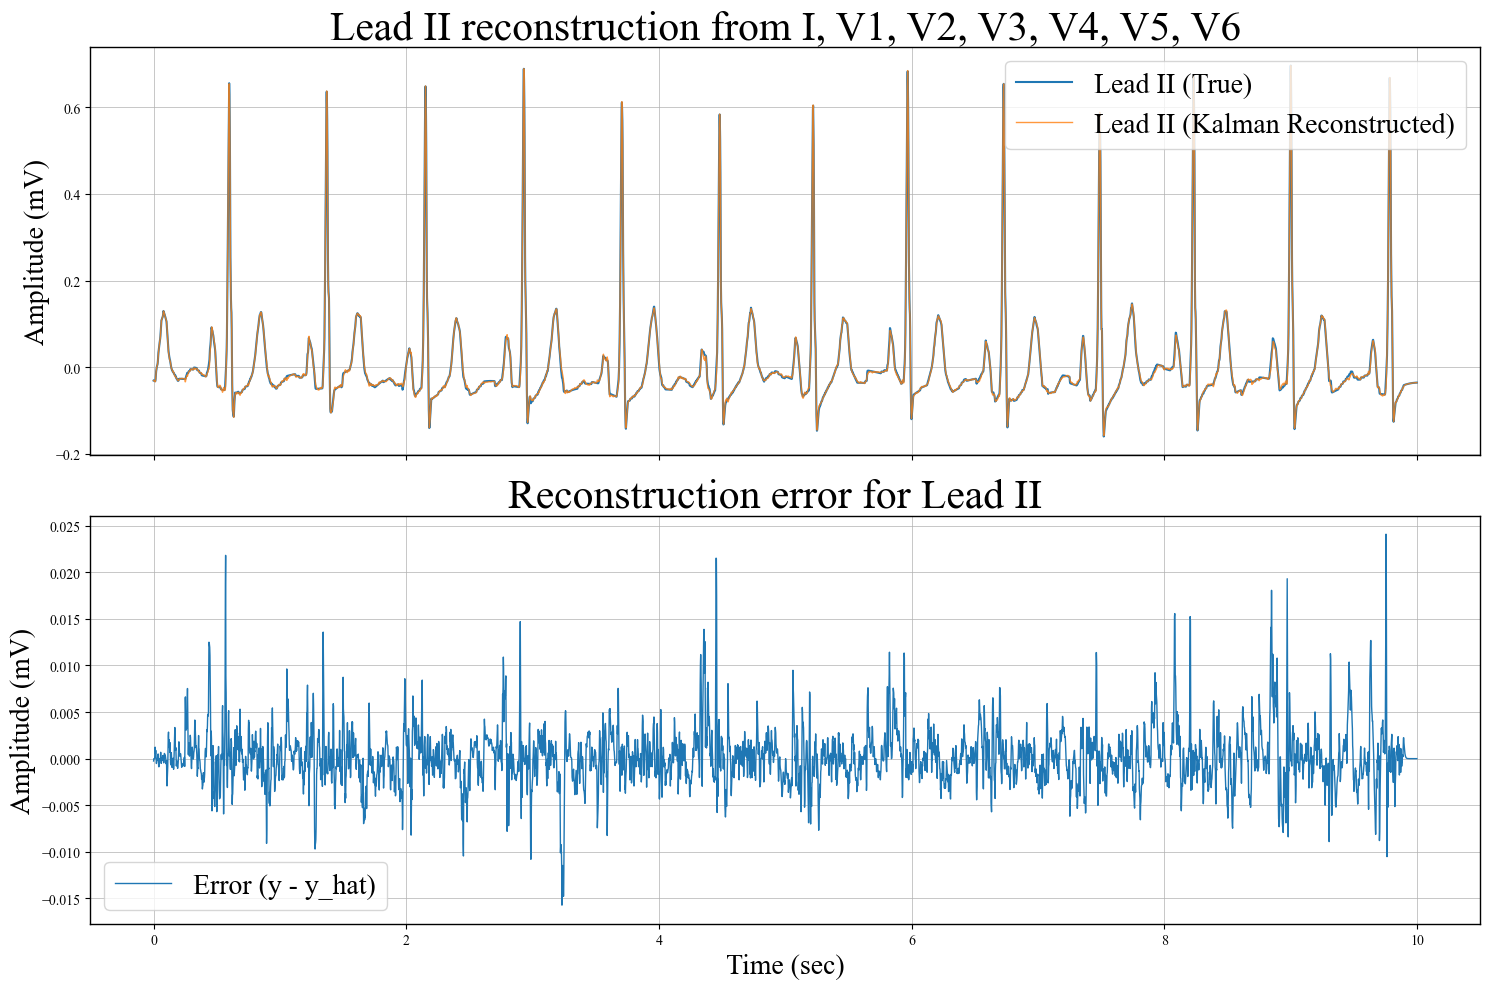

In [116]:
import matplotlib.pyplot as plt
import numpy as np
from ecg_utils import load_ecg, preprocess_data, compute_snr

# All available leads
all_leads = ["I", "II", "V1", "V2", "V3", "V4", "V5", "V6"]

# Choose which lead you want to reconstruct
target_lead = "II"
order = 4

# --- pull the best q/r for this target lead from your earlier run ---
# assumes you already computed `results = {...}` using run_one_target_lead
q_var = results[target_lead]["q_var"]
r_var = results[target_lead]["r_var"]

# Inputs are all other leads
input_leads = [ld for ld in all_leads if ld != target_lead]

# Pick any record to visualize (make sure index exists)
idx = 413  # change to 999 if you truly have >=1000 val records
record_path = record_paths_val[idx]
print("Visualizing record:", record_path)

# Target first, then inputs
selected_leads = [target_lead] + input_leads
signal, record = load_ecg(record_path, selected_leads=selected_leads)
fs = record.fs

signal = preprocess_data(signal, fs)

# y = target lead (true), x = all other leads (multi-input)
y = signal[:, 0]
x = signal[:, 1:]

# Kalman multi-lead FIR
y_hat, h_hist, innovations, K_hist, S_hist, P_diag_hist,_ = kalman_adaptive_fir_multi(
    x=x,
    y=y,
    order=order,
    q_var=q_var,
    r_var=r_var
)

# Valid indices (your implementation is zero-padded, usually all finite)
valid = np.isfinite(y_hat) & np.isfinite(y)

snr_val = compute_snr(y[valid], y_hat[valid]) if np.any(valid) else np.nan
print(f"q_var={q_var:.3e}, r_var={r_var:.3e}")
print(f"SNR for this record = {snr_val:.2f} dB")

t = np.arange(len(y)) / fs

# ----------------------------
# Combined figure with subplots
# ----------------------------
fig, axes = plt.subplots(2, 1, figsize=(15, 10), sharex=True)

# Common quantities
err = y - y_hat
shift = -0.5

# ----------------------------
# Subplot 1: True vs Reconstructed + shifted error
# ----------------------------
axes[0].plot(t, y, label=f"Lead {target_lead} (True)", linewidth=1.5)
axes[0].plot(
    t[valid],
    y_hat[valid],
    label=f"Lead {target_lead} (Kalman Reconstructed)",
    alpha=0.8
)
# # axes[0].plot(
#     t[valid],
#     err[valid] + shift,
#     label=f"Error (y - y_hat) + {shift}",
#     linewidth=1.0
# )

axes[0].set_ylabel("Amplitude (mV)", fontsize=20)
axes[0].set_title(
    f"Lead {target_lead} reconstruction from {', '.join(input_leads)}"
    , fontsize=30
)
axes[0].legend(fontsize=20, loc="upper right")
axes[0].grid(True)

# ----------------------------
# Subplot 2: Error only
# ----------------------------
axes[1].plot(
    t[valid],
    err[valid],
    label="Error (y - y_hat)",
    linewidth=1.0
)

axes[1].set_xlabel("Time (sec)",fontsize=20)
axes[1].set_ylabel("Amplitude (mV)",fontsize=20)
axes[1].set_title(
    f"Reconstruction error for Lead {target_lead}  "
    , fontsize=30
)
axes[1].legend(fontsize=20)
axes[1].grid(True)

plt.tight_layout()
plt.savefig("reconstructed_signal.png")
plt.show()


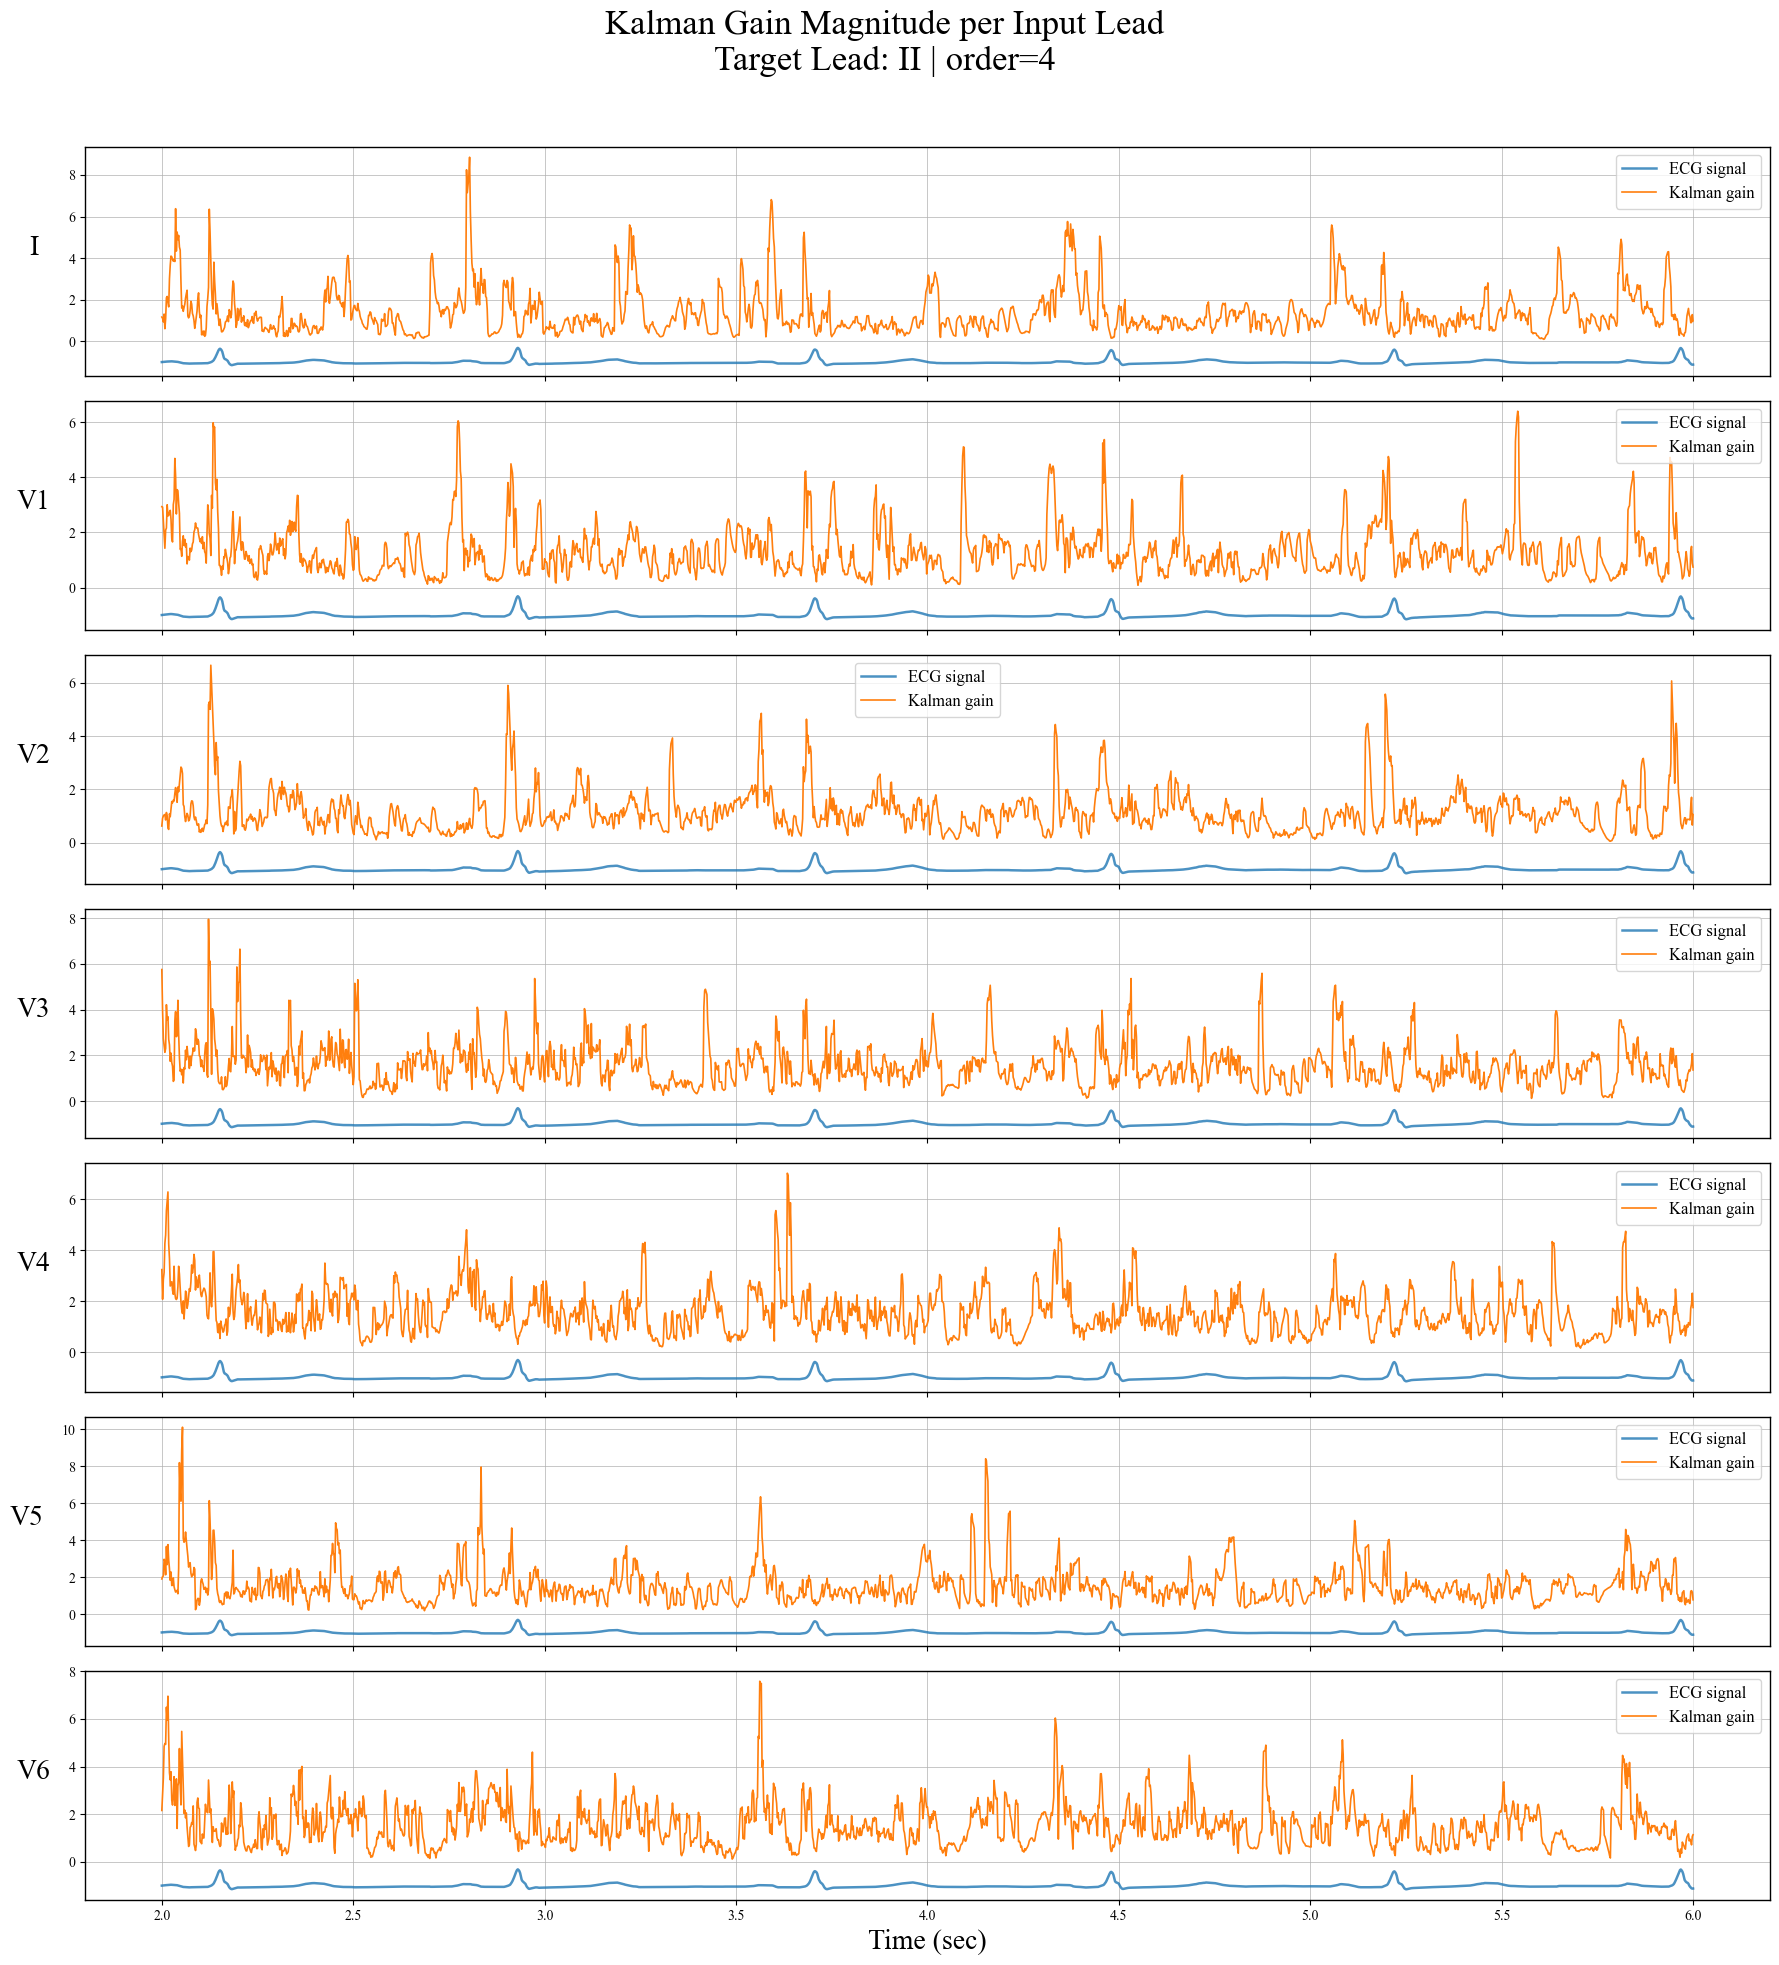

In [118]:
#
#  Reshape Kalman gain: (T, q+1, L)
L_in = 7 
K3 = K_hist.reshape(len(y), order + 1, L_in)

# Aggregate across lags → one gain curve per lead
K_lead = np.linalg.norm(K3, axis=1)  # shape (T, L)
t0, t1 = 2.0, 6.0  # seconds
mask = (t >= t0) & (t <= t1)

t_plot = t[mask]
K_plot = K_lead[mask]

# -------- Kalman gain subplot (7 x 1) --------
L_in = x.shape[1]
assert L_in == 7, f"Expected 7 input leads, got {L_in}"



fig, axes = plt.subplots(7, 1, figsize=(18, 20), sharex=True)

for i, (ax, ld) in enumerate(zip(axes, input_leads)):
    # if i ==0: 
    #     ax.plot(t[mask], y[mask]*3, label=f"Lead {target_lead} (True)", linewidth=1.5)
    #     ax.grid(True)
    ax.plot(
    t[mask], y[mask]-1,
    label=f"ECG signal",
    alpha=0.8, linewidth=1.8
)
    ax.plot(t_plot, K_plot[:, i],label = "Kalman gain", linewidth=1.2)
    ax.set_ylabel(f"{ld}", rotation=0, labelpad=25, fontsize=20)
    ax.legend(fontsize=12)
    ax.grid(True)


axes[-1].set_xlabel("Time (sec)",fontsize=20)

fig.suptitle(
    f"Kalman Gain Magnitude per Input Lead\n"
    f"Target Lead: {target_lead} | order={order}",
    fontsize=25
)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.savefig("kalman_gain.png")
plt.show()


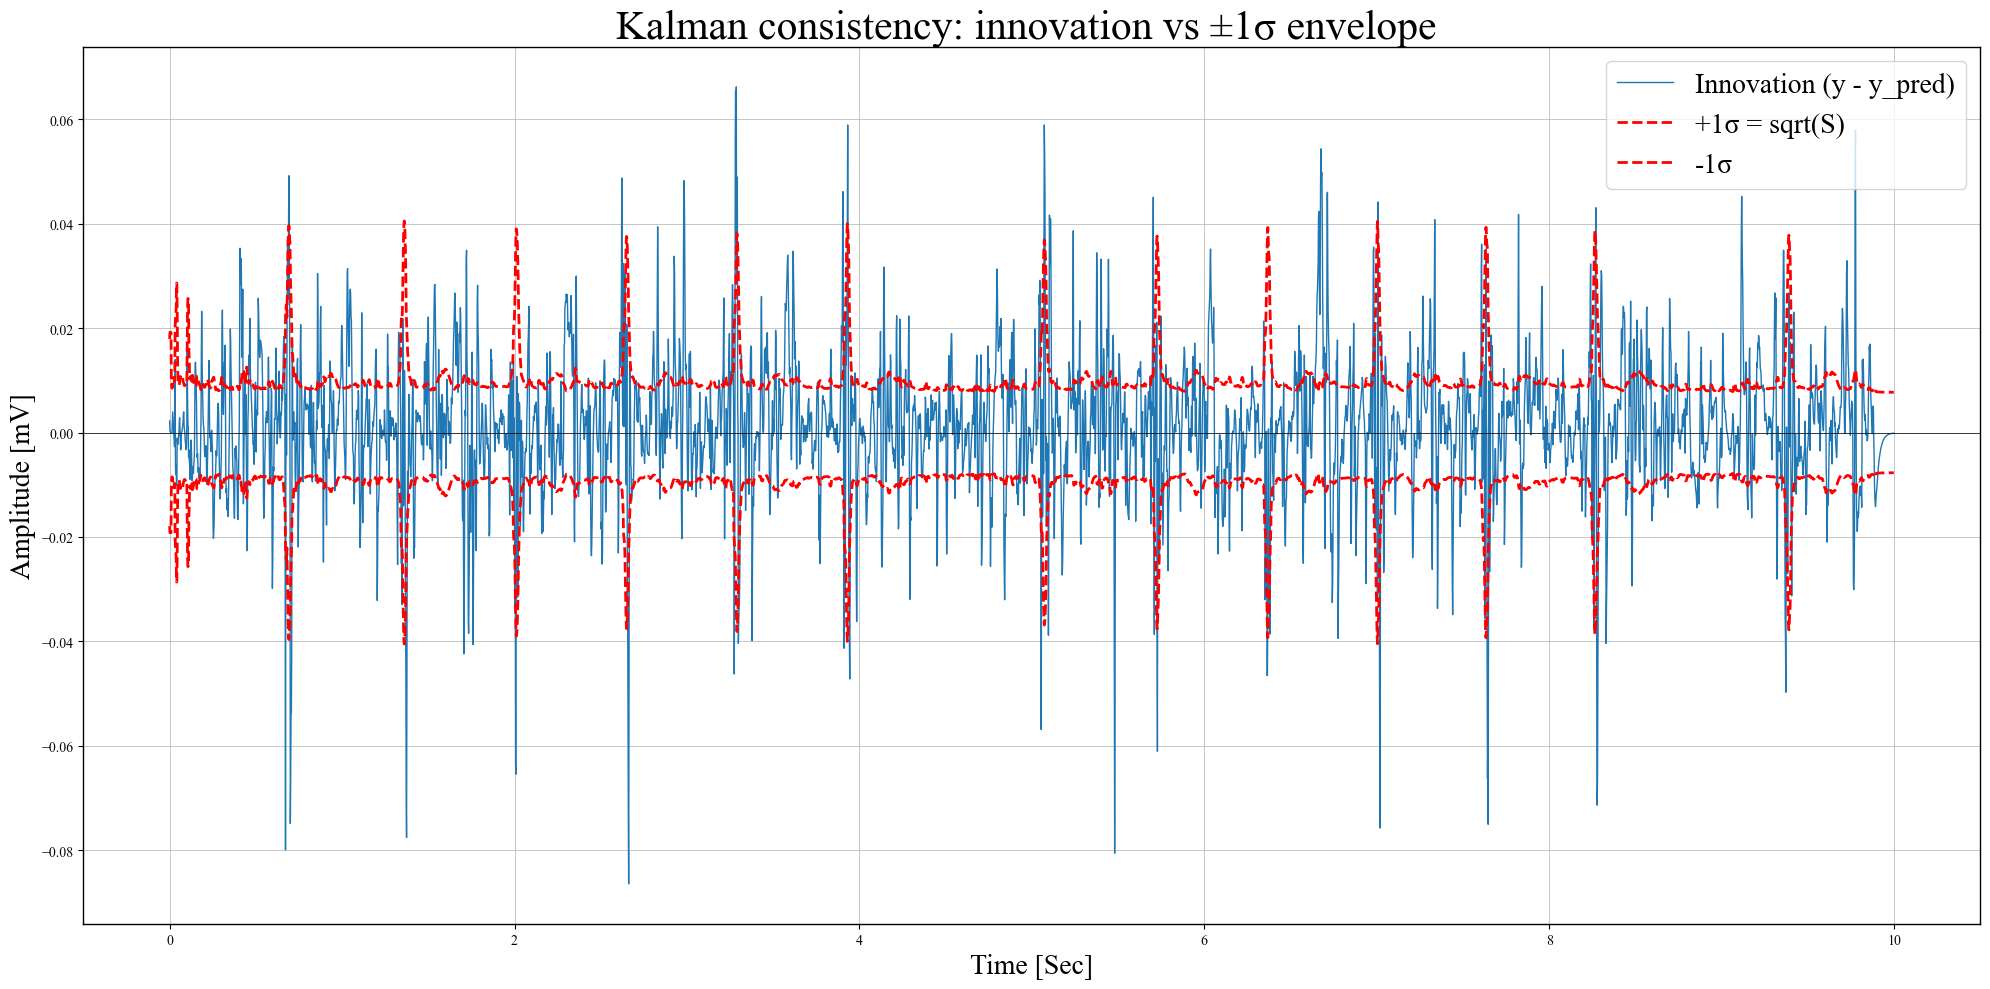

Percent inside ±1σ: 0.68% (ideal ≈ 68%)
0.8347138
0.12110663751240061
0.7870381034291751
0.9926173209040139


In [131]:
target_lead = "II"
plts = 1 
inside_vec = [] 
nis_vec = []
for j in range(len(results[target_lead]["innovations_list"])):


    innov = results[target_lead]["innovations_list"][j]
    S_hist = results[target_lead]["S_hist_list"][j]

    valid = np.isfinite(innov) & np.isfinite(S_hist) & (S_hist > 0)
    sigma = np.sqrt(S_hist[valid])
    if j ==70 :
        plt.figure(figsize=(20,10))
        plt.plot(t[valid], innov[valid], linewidth=1.0, label="Innovation (y - y_pred)")
        plt.plot(t[valid], +sigma, 'r--', linewidth=2.0, label="+1σ = sqrt(S)")
        plt.plot(t[valid], -sigma, 'r--', linewidth=2.0, label="-1σ")
        plt.axhline(0, color='k', linewidth=0.5)
        plt.grid(True)
        plt.legend(loc="upper right",fontsize=20)
        plt.title("Kalman consistency: innovation vs ±1σ envelope ",fontsize=30)
        plt.xlabel("Time [Sec]",fontsize=20)
        plt.ylabel("Amplitude [mV]",fontsize=20)
        plt.tight_layout()
        plt.savefig("guassian_check.png")
        plt.show()
        inside = (np.abs(innov[valid]) <= sigma).mean() 
        print(f"Percent inside ±1σ: {inside:.2f}% (ideal ≈ 68%)")

    inside = (np.abs(innov[valid]) <= sigma).mean() 
    inside_vec.append(inside)
    # print(f"Percent inside ±1σ: {inside:.2f}% (ideal ≈ 68%)")
    nis = (innov[valid]**2) / S_hist[valid]
    nis_vec.append(nis.mean())


print(np.mean(inside_vec))
print(np.std(inside_vec))
print(np.mean(nis_vec))
print(np.std(nis_vec))



In [64]:
print(np.mean(inside_vec))
print(np.std(inside_vec))
print(np.mean(nis_vec))
print(np.std(nis_vec))

0.8347138
0.12110663751240061
0.7870381034291751
0.9926173209040139


Total innovation samples: 40000000


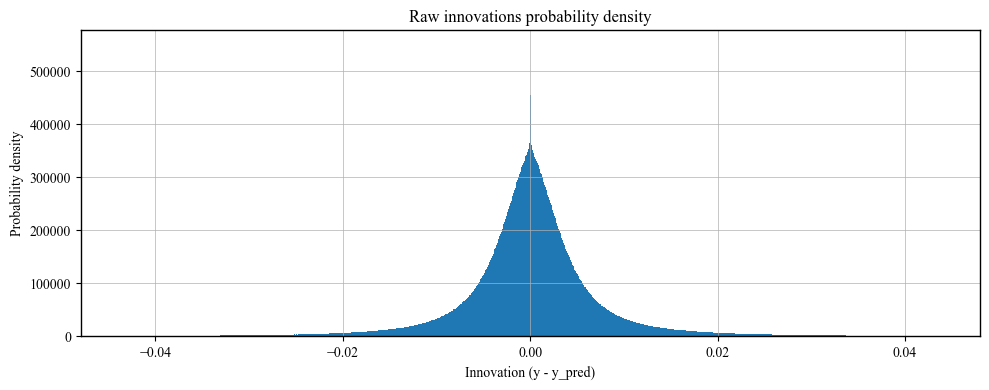

In [111]:
import numpy as np
import matplotlib.pyplot as plt

all_innov = []
all_z = []
all_nis = []

for lead in leads:
    for innov, S_hist in zip(results[lead]["innovations_list"], results[lead]["S_hist_list"]):
        innov = np.asarray(innov)
        S_hist = np.asarray(S_hist)

        valid = np.isfinite(innov) & np.isfinite(S_hist) & (S_hist > 0)
        if not np.any(valid):
            continue

        nu = innov[valid]

        all_innov.append(nu)


# Concatenate into 1D arrays
all_innov = np.concatenate(all_innov) if all_innov else np.array([])

print("Total innovation samples:", all_innov.size)

x = all_innov
lo, hi = np.percentile(x, [0.5, 99.5])   # adjust as you like: [1,99], [0.1,99.9], etc.
x_clip = (x[(x >= lo) & (x <= hi)])

plt.figure(figsize=(10,4))
plt.hist(x_clip, bins=1000, density=False)
plt.title("Raw innovations probability density")
plt.xlabel("Innovation (y - y_pred)")
plt.ylabel("Probability density")
plt.grid(True)
plt.tight_layout()
plt.savefig("hist.png")
plt.show()




(39600000,)